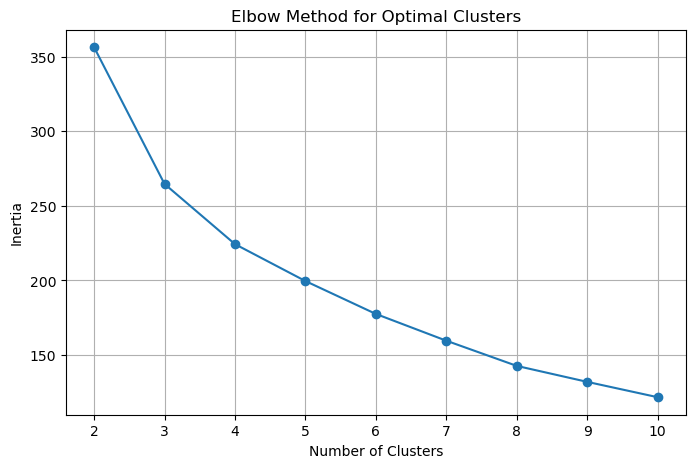

Davies-Bouldin Index: 1.22
Silhouette Score: 0.25


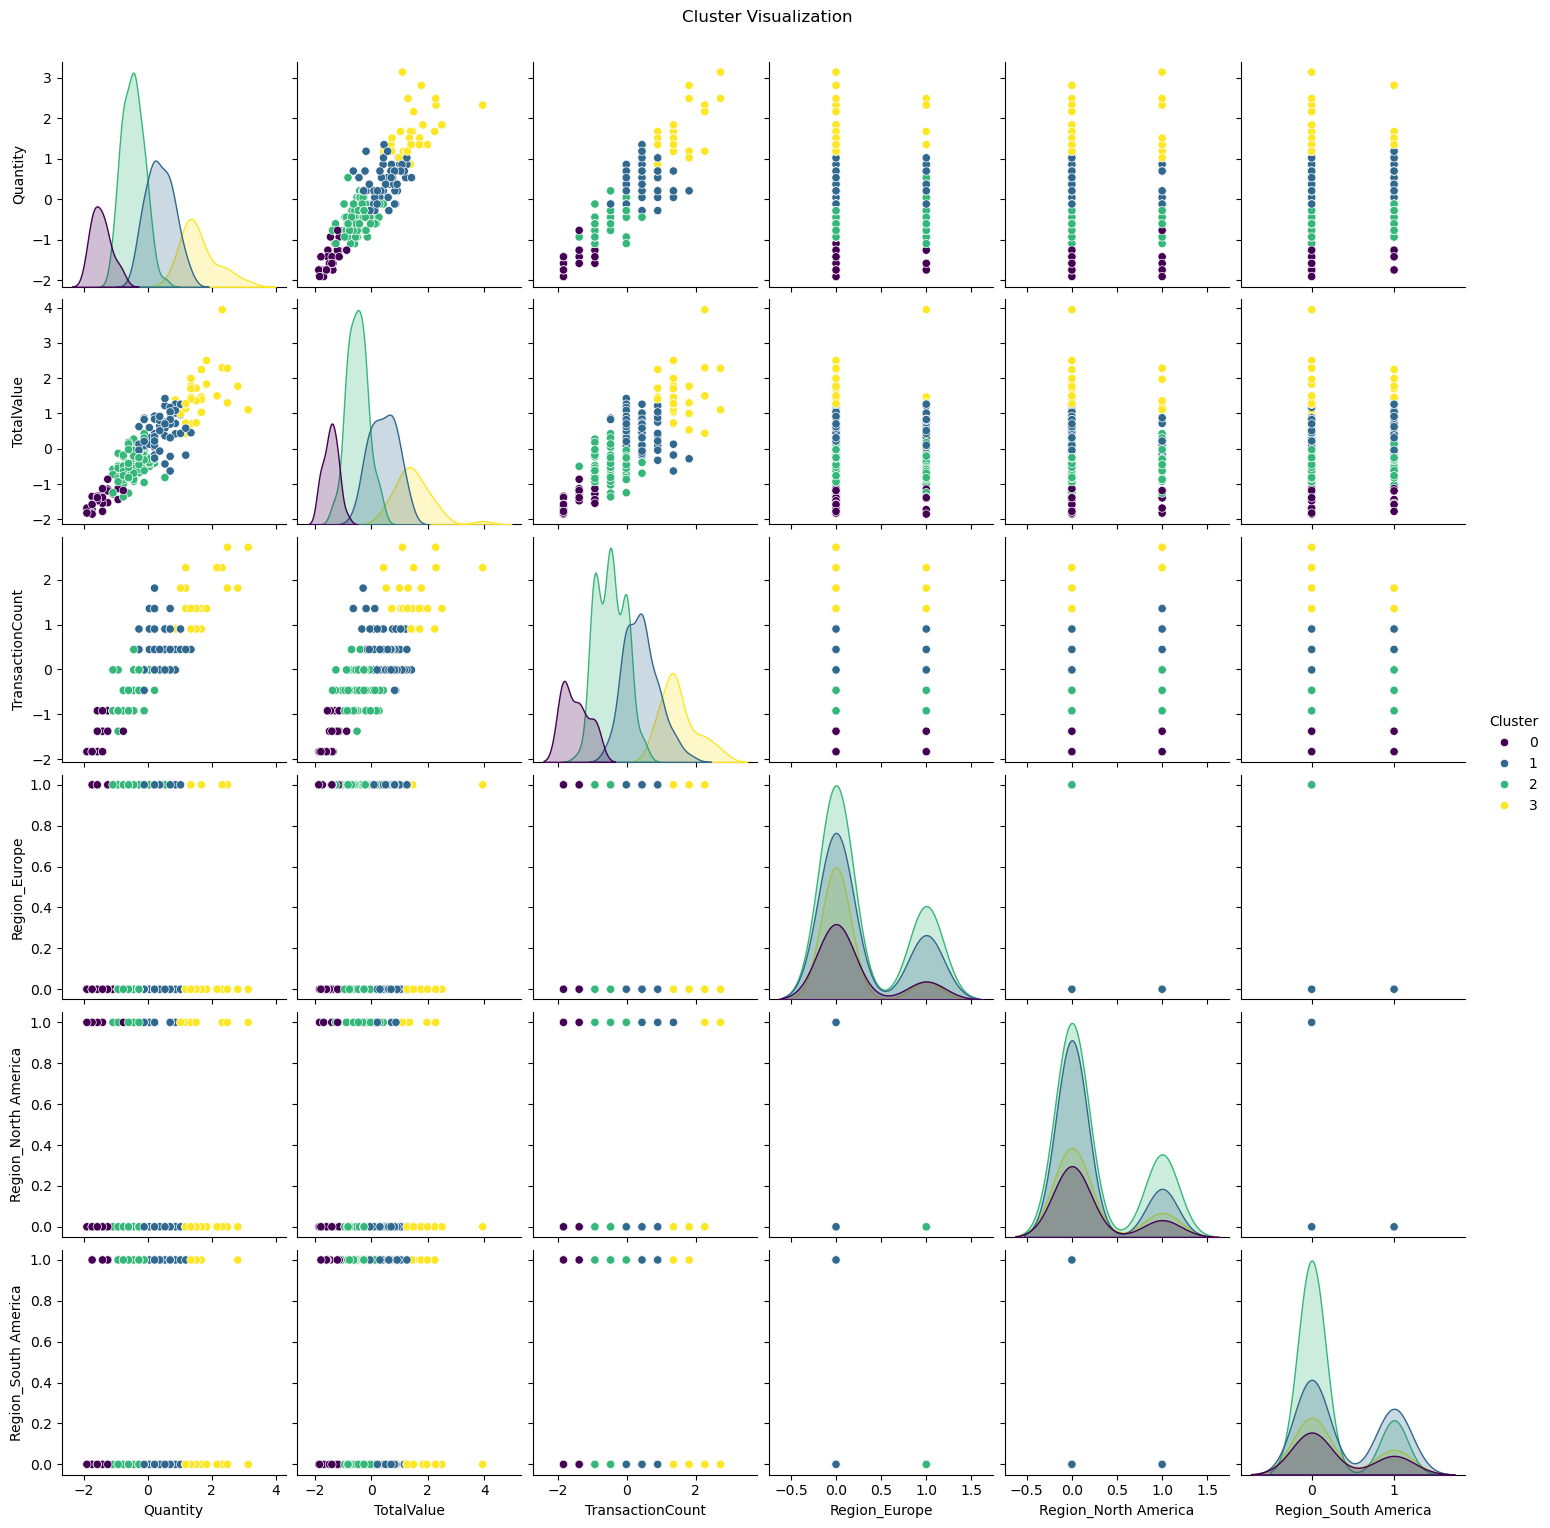

         Quantity  TotalValue  TransactionCount  CustomerCount
Cluster                                                       
0       -1.469782   -1.432989         -1.484805             26
1        0.374933    0.432296          0.414674             61
2       -0.472757   -0.489047         -0.461722             79
3        1.596703    1.500680          1.508662             33


In [13]:
# Customer Segmentation / Clustering for eCommerce Dataset

# Importing necessary libraries
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Fix for MKL memory leak on Windows

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv("D:/Practicals/Customers.csv")
transactions = pd.read_csv("D:/Practicals/Transactions.csv")

# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID", how="left")

# Aggregate transaction data to create customer profiles
customer_profiles = merged_data.groupby("CustomerID").agg({
    "Quantity": "sum",           # Total quantity purchased
    "TotalValue": "sum",         # Total value of transactions
    "TransactionID": "count"     # Number of transactions
}).rename(columns={"TransactionID": "TransactionCount"}).reset_index()

# Add customer-specific details (e.g., Region)
customer_profiles = customer_profiles.merge(customers[["CustomerID", "Region"]], on="CustomerID", how="left")

# Encode categorical data (e.g., Region) using one-hot encoding
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"], drop_first=True)

# Standardize the numerical data
scaler = StandardScaler()
numerical_features = ["Quantity", "TotalValue", "TransactionCount"]
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_profiles.drop("CustomerID", axis=1))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (e.g., 4 based on the elbow curve)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_profiles["Cluster"] = kmeans.fit_predict(customer_profiles.drop("CustomerID", axis=1))

# Calculate Clustering Metrics
db_index = davies_bouldin_score(customer_profiles.drop(["CustomerID", "Cluster"], axis=1), customer_profiles["Cluster"])
silhouette_avg = silhouette_score(customer_profiles.drop(["CustomerID", "Cluster"], axis=1), customer_profiles["Cluster"])

print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Visualize the clusters using Pairplot
sns.pairplot(customer_profiles, hue="Cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Cluster Visualization", y=1.02)
plt.show()

# Save the cluster results to a CSV file
customer_profiles[["CustomerID", "Cluster"]].to_csv("D:/Practicals/CustomerClusters.csv", index=False)

# Print summary of clusters
cluster_summary = customer_profiles.groupby("Cluster").agg({
    "Quantity": "mean",
    "TotalValue": "mean",
    "TransactionCount": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "CustomerCount"})
print(cluster_summary)
